In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

In [3]:
np.set_printoptions(suppress=True)

In [4]:
# Simulating a moving average model of 2nd order
np.random.seed(110)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_generator = ArmaProcess(ar2, ma2)

MA2_process = MA2_generator.generate_sample(nsample=1000)

MA2_process

array([ 0.3285971 , -0.50046116,  0.78512427, -0.52384087,  0.19465397,
        1.73344209,  1.5130788 ,  0.89283755, -0.44100684, -0.62490171,
       -1.75479172, -2.17427892, -1.41326451, -3.07703825, -2.38821078,
       -1.12407029, -0.48800965, -1.00455055,  0.35002166,  0.0041803 ,
       -1.80808793,  0.25272302, -0.48708808, -1.01604043, -0.30850034,
        1.77906034,  3.05942815,  0.63955285, -0.11169404, -0.733005  ,
       -0.49341213, -0.64070102, -1.05077193, -1.4945833 ,  0.68096943,
        0.44039469,  0.0170466 ,  0.12636813, -0.48009211, -0.00638656,
       -0.1325166 ,  0.52050398,  0.5050592 ,  1.17481467,  1.78462854,
        1.0950811 ,  0.94304029,  1.77276179,  2.38317922,  1.03561168,
       -0.63510437, -0.85604003, -1.41385842, -0.57561697, -0.23159483,
        0.28079908,  0.39928026, -0.59097449, -0.58530867,  1.79558688,
        1.86380816,  0.4706237 ,  0.63123747,  1.42108164, -1.31607484,
       -2.20154768, -1.50193218, -2.85365194, -1.67169203, -0.60

Text(0, 0.5, 'Value')

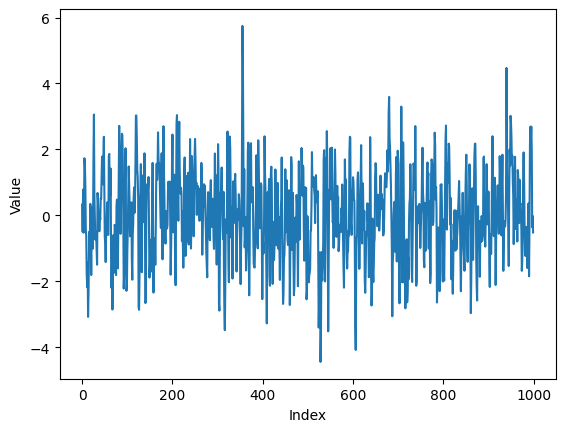

In [5]:
fig, ax = plt.subplots()
ax.plot(MA2_process)
ax.set_xlabel("Index")
ax.set_ylabel("Value")

In [6]:
# Turn it into a dataframe
MA2_df = pd.DataFrame({"Value":MA2_process})
MA2_df.head()

,Value
0,0.328597
1,-0.500461
2,0.785124
3,-0.523841
4,0.194654


In [7]:
# Checking stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

adf_test = adfuller(MA2_df.Value)
print(f"Test value {adf_test[0]} with p of {adf_test[1]}")


Test value -15.188959343672355 with p of 6.048447291979509e-28


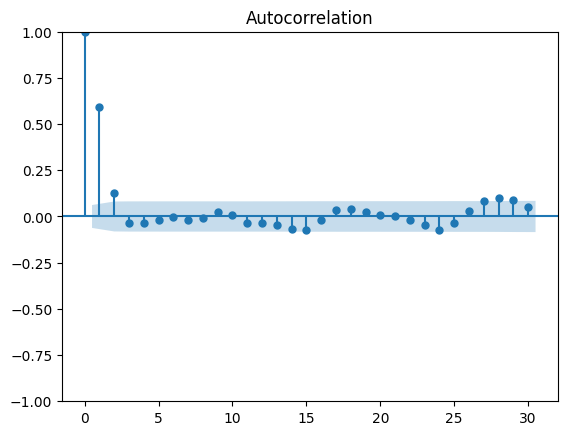

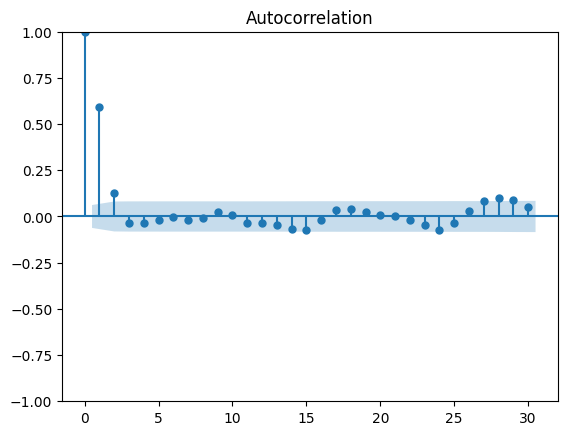

In [8]:
plot_acf(MA2_df.Value)

In [9]:
diff_df = pd.DataFrame({"Value": MA2_df.Value.diff(1)[1:]})
diff_df.head()

,Value
1,-0.829058
2,1.285585
3,-1.308965
4,0.718495
5,1.538788


In [10]:
adf_test = adfuller(diff_df.Value)
print(f"Test value {adf_test[0]} with p of {adf_test[1]}")

Test value -12.156622957182556 with p of 1.5268380212676348e-22


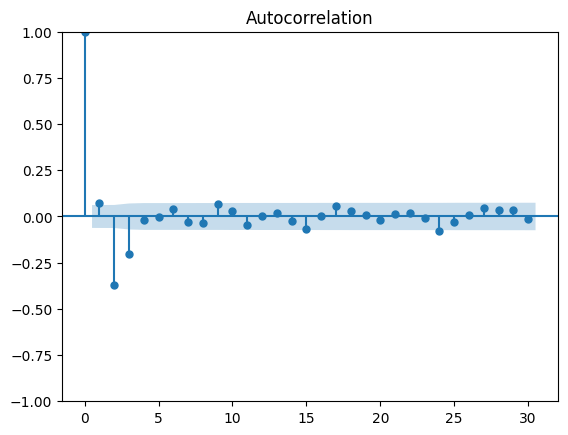

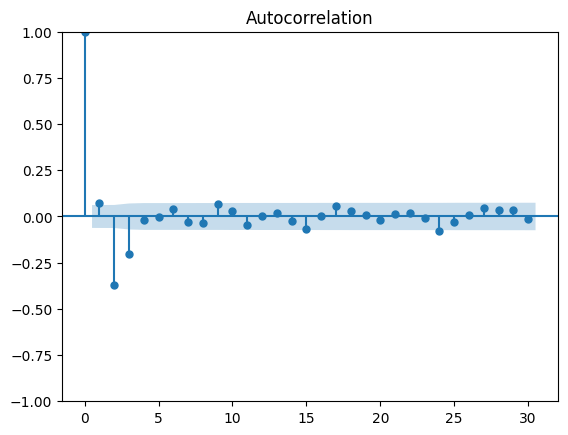

In [11]:
plot_acf(diff_df.Value)
# Jedan lag više od očekivanog. Zato što je već diff? Očekivao bih da bude jedan MANJE onda

In [12]:
# Split
training = diff_df[:800]
test = diff_df[800:].copy(deep=True)
test.shape[0]
# 199 u testu jer jedan redak smo izgubili na diff

199

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def recursive_forc_last(df: pd.DataFrame,
                        train_len: int,
                        horizon: int,
                        window: int):
    total_len = train_len + horizon

    pred_last_value = []
    for i in np.arange(train_len, total_len, window):
        endpoint = i -1 + window
        # The very last datapoint can't be included because that's the last value for (total_len + 1) th point!
        if (endpoint > (total_len - 1)):
            endpoint = total_len - 1 # equal to last index in data. iloc is exclusive - won't be included
        last_val = df.iloc[(i -1):endpoint].Value
        pred_last_value.extend(last_val)
    
    return pred_last_value


In [14]:
predicted_lastv = recursive_forc_last(diff_df,
                    len(training),
                    len(test),
                    window = 2)
print(f"Predicted {len(predicted_lastv)} values")

Predicted 199 values


In [47]:
def recursive_forc_ma(df: pd.DataFrame,
                        train_len: int,
                        horizon: int,
                        window: int):
    total_len = train_len + horizon
    

    pred_mv = []
    for i in np.arange(train_len, total_len, window):
        # Train the model parameters on this subset of data
        model = SARIMAX(df[:i], order=(0,0,window))
        res = model.fit(disp=False)
        endpoint = i + window - 1

        # We can go over the horizon if the window is large,
        # The last batch doesn't necessarily have to return "window" values

        predictions = res.get_prediction(0,
                                           endpoint)
        # This object contains multiple attributes, the "pure" prediction is the mean
        last_val = predictions.predicted_mean.iloc[-window:]

        pred_mv.extend(last_val)
    
    if len(pred_mv) > horizon:
        pred_mv = pred_mv[:horizon]


    return pred_mv

In [16]:
test.head()

,Value
801,-1.577013
802,-0.276538
803,1.541825
804,1.310792
805,1.428292


In [17]:
# If we go over with iloc?
test.iloc[197:205].Value

# Ok, the "extras" are not returned, so the last_value works correctly

998    0.341989
999   -0.499277
Name: Value, dtype: float64

In [18]:
train_len = len(training)
print(train_len)
horizon = len(test)
print(horizon)
window = 2
total_len = train_len + horizon
np.arange(train_len, total_len, window)

800
199


array([800, 802, 804, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824,
       826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850,
       852, 854, 856, 858, 860, 862, 864, 866, 868, 870, 872, 874, 876,
       878, 880, 882, 884, 886, 888, 890, 892, 894, 896, 898, 900, 902,
       904, 906, 908, 910, 912, 914, 916, 918, 920, 922, 924, 926, 928,
       930, 932, 934, 936, 938, 940, 942, 944, 946, 948, 950, 952, 954,
       956, 958, 960, 962, 964, 966, 968, 970, 972, 974, 976, 978, 980,
       982, 984, 986, 988, 990, 992, 994, 996, 998])

In [19]:
predicted_ma = recursive_forc_ma(diff_df,
                    len(training),
                    len(test),
                    window = 2)
print(f"Predicted {len(predicted_ma)} values")

Predicted 199 values


In [20]:
test["last_val"] = predicted_lastv
test["pred_ma"] = predicted_ma
test

,Value,last_val,pred_ma
801,-1.577013,1.882534,0.430960
802,-0.276538,-1.577013,-0.327744
803,1.541825,-0.276538,1.527363
804,1.310792,1.541825,0.409950
805,1.428292,1.310792,-0.314149
...,...,...,...
995,0.436982,-0.434882,-1.492425
996,-0.648566,0.436982,-0.746577
997,-2.402866,-0.648566,-1.528422
998,0.341989,-2.402866,-0.494528


In [21]:
# De-diffing!
starter = MA2_df.iloc[len(training) - 1].Value

act_last = starter + np.cumsum(test.last_val)
act_ma = starter + np.cumsum(test.pred_ma)

In [22]:
MA2_df["last_val"] = pd.Series()
MA2_df["pred_ma"] = pd.Series()

MA2_df["last_val"] = act_last
MA2_df["pred_ma"] = act_ma
MA2_df.tail()

,Value,last_val,pred_ma
995,2.692666,2.255684,-10.275988
996,2.044100,2.692666,-11.022565
997,-0.358766,2.044100,-12.550987
998,-0.016776,-0.358766,-13.045514
999,-0.516054,-0.016776,-12.649095


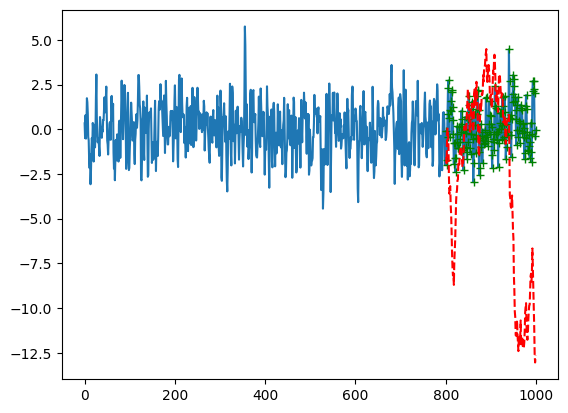

In [23]:
# Plot forecasts
fig, ax = plt.subplots()
ax.plot(MA2_df.Value)
ax.plot(MA2_df.last_val, "g+", label = "Last")
ax.plot(MA2_df.pred_ma, "r--", label = "Pred MA")

# Nije trebalo uzimati diffs jer je već stacionarno

Taj korak potreban kod baratanja sa stvarnim podacima, koji se ISPRVE ne ponašaju tako da zadovoljaavju pretpostavke modela.

Sa diffs, imali smo lagove do 3!!

In [24]:
MA2_df.drop(["last_val", "pred_ma"], axis = 1, inplace=True)

In [25]:
# Split
training = MA2_df[:800]
test = MA2_df[800:].copy(deep=True)
test.shape[0]

200

In [26]:
predicted_lastv = recursive_forc_last(MA2_df,
                    len(training),
                    len(test),
                    window = 2)
print(f"Predicted {len(predicted_lastv)} values")

Predicted 200 values


In [27]:
predicted_ma = recursive_forc_ma(MA2_df,
                    len(training),
                    len(test),
                    window = 2)
print(f"Predicted {len(predicted_ma)} values")

Predicted 200 values


In [28]:
# Prvo spajanje s test da idu u dobre indexe
test["last_val"] = predicted_lastv
test["pred_ma"] = predicted_ma


MA2_df["last_val"] = pd.Series()
MA2_df["pred_ma"] = pd.Series()

MA2_df["last_val"] = test["last_val"]
MA2_df["pred_ma"] = test["pred_ma"]
MA2_df.tail()

,Value,last_val,pred_ma
995,2.692666,2.255684,0.296493
996,2.044100,2.692666,1.628169
997,-0.358766,2.044100,0.446540
998,-0.016776,-0.358766,-0.882556
999,-0.516054,-0.016776,-0.327146


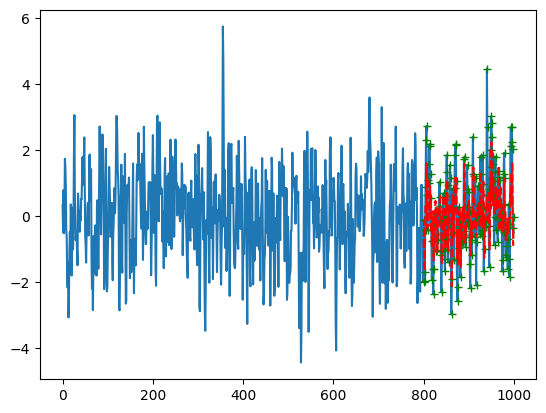

In [29]:
# Plot forecasts
fig, ax = plt.subplots()
ax.plot(MA2_df.Value)
ax.plot(MA2_df.last_val, "g+", label = "Last")
ax.plot(MA2_df.pred_ma, "r--", label = "Pred MA")

In [30]:
# Error metrics

from sklearn.metrics import mean_squared_error

mse_last = mean_squared_error(test['Value'], test['last_val'])
mse_MA = mean_squared_error(test['Value'], test['pred_ma'])

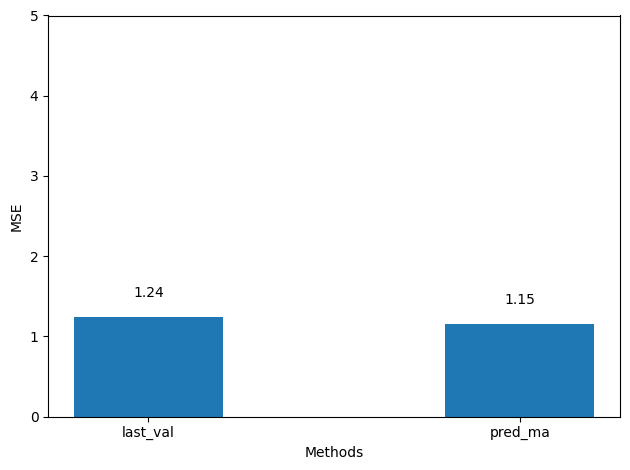

In [31]:
fig, ax = plt.subplots()

x = ["last_val", "pred_ma"]
y = [mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# MA(q) - q = 4, 4th order MA 

In [32]:
# Generating a 4th order MA model

ma4 = np.array([1, 0.6, 0.3, 0.6, 0.4])
ar4 = np.array([1, 0, 0, 0])
ma4_generator = ArmaProcess(ar4, ma4)
ma4_process = ma4_generator.generate_sample(10000)
ma4_process

array([ 0.79204162, -0.41130269, -0.24474755, ...,  0.01203551,
        0.89622327,  1.03743471])

Figure(640x480)


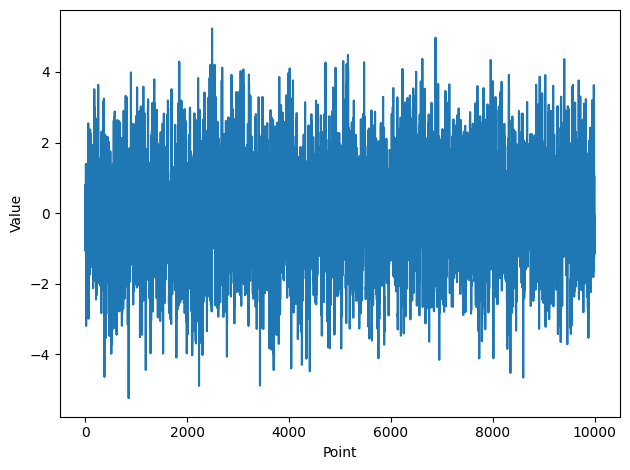

In [49]:
fig, ax = plt.subplots()
ax.plot(ma4_process)
ax.set_xlabel("Point")
ax.set_ylabel("Value")
fig.tight_layout()
print(fig)

Figure(640x480)


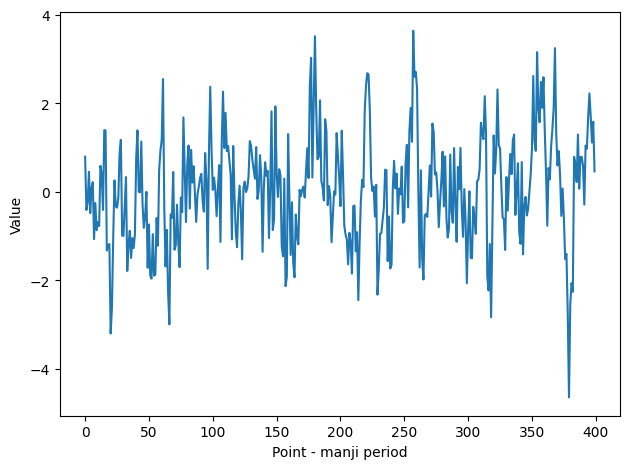

In [50]:
fig, ax = plt.subplots()
ax.plot(ma4_process[:400])
ax.set_xlabel("Point - manji period")
ax.set_ylabel("Value")
fig.tight_layout()
print(fig)

Figure(640x480)


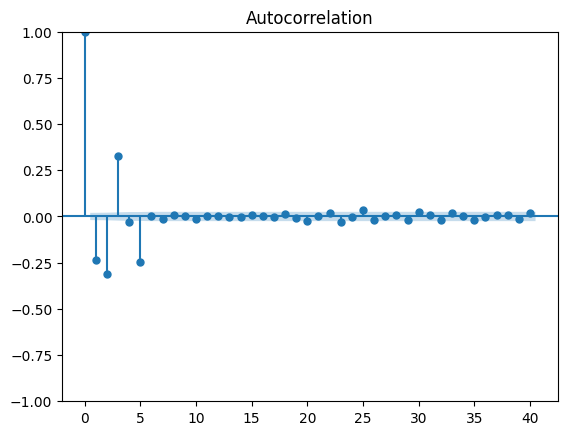

In [37]:
# Testing for random walk
diffs = np.diff(ma4_process)
adfuller(diffs)[0:2]
print(plot_acf(diffs))
# Not a random walk because of autocorrelations

Figure(640x480)


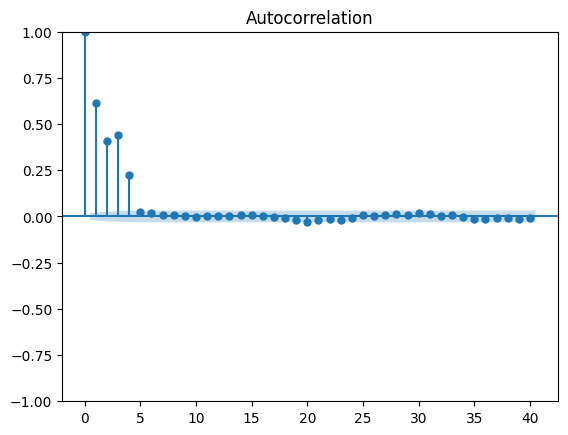

In [38]:
# Testing for MA model
adfuller(ma4_process)[0:2]
print(plot_acf(ma4_process))

In [39]:
ma4_df = pd.DataFrame({"Value":ma4_process})

training = ma4_df[:8000]
testing = ma4_df[8000:]
testing.tail()

,Value
9995,-0.209497
9996,-1.161375
9997,0.012036
9998,0.896223
9999,1.037435


In [43]:
pred_last = recursive_forc_last(ma4_df,
                    train_len=len(training),
                    horizon = 2000,
                    window = 4)

In [48]:
pred_ma = recursive_forc_ma(ma4_df,
                    train_len=len(training),
                    horizon = 2000,
                    window = 4)

In [52]:
testing.loc[:, "last"] = pred_last
testing.loc[:, "ma"] = pred_ma

In [53]:
testing

,Value,last,ma
8000,-0.344553,1.158913,0.336456
8001,0.120734,-0.344553,0.423237
8002,1.077984,0.120734,1.048571
8003,1.404354,1.077984,0.405897
8004,1.599502,1.404354,0.605613
...,...,...,...
9995,-0.209497,-0.776396,-0.216968
9996,-1.161375,-0.209497,-0.029375
9997,0.012036,-1.161375,0.209318
9998,0.896223,0.012036,0.107529


In [54]:
mae_last = mean_squared_error(testing["Value"], testing["last"])
mae_ma = mean_squared_error(testing["Value"], testing["ma"])

f"Last value {mae_last}, and MA {mae_ma}"

'Last value 1.4671967440348186, and MA 1.3771418291924646'

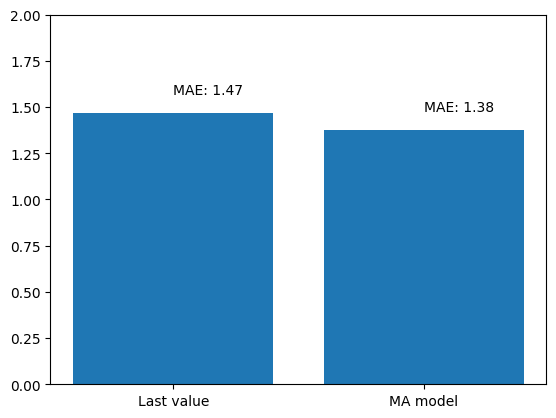

In [63]:
# Plot relative
fig, ax = plt.subplots()
x = ["Last value", "MA model"]
y = [mae_last, mae_ma]
ax.bar(x, y)
ax.set_ylim(0, 2)
for i,v in enumerate(y):
    ax.text(x = i, y = v + 0.1, s = f"MAE: {v:.2f}")